In [232]:
import pandas as pd
import pandas_gbq
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%load_ext google.cloud.bigquery

# Set your default project here
pandas_gbq.context.project = 'bigquery-public-data'
pandas_gbq.context.dialect = 'standard'

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


# Load Data

The BigQuery Python client library provides a magic command that allows you to run queries with minimal code.

The BigQuery client library provides a cell magic, %%bigquery. The %%bigquery magic runs a SQL query and returns the results as a pandas `DataFrame`

TODO:
- [ ] Slide 1 - Executive Summary
- [ ] Slide 2 - Brooklyn vs rest of NY, why is Brooklyn an issue?
- [ ] Slide 3 - Focus on Brooklyn: main causes, day of accidents, correlation with weather, map of incidents
- [ ] Slide 4 - Recommendations: Dashboard with live updates, campaign against distraction, future steps (correlation with weather)
- [ ] Slide 5 - Technicalities and approach taken to analysis 

## Slide 2 - Brooklyn vs rest of NY, why is Brooklyn an issue?

In [233]:
%%bigquery injured_df
#number of injured per day, by borough
SELECT
  date(timestamp) as date,
  borough,
  SUM(number_of_persons_injured) as tot_injured
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  borough != ''
GROUP BY
  borough,
  date(timestamp) 

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10155/10155 [00:01<00:00, 6216.29rows/s]


In [234]:
injured_df

,date,borough,tot_injured
0,2018-01-17,QUEENS,20
1,2015-05-08,MANHATTAN,29
2,2017-11-22,QUEENS,28
3,2017-12-05,BRONX,11
4,2017-11-03,BRONX,27
...,...,...,...
10150,2016-06-05,STATEN ISLAND,2
10151,2015-01-11,STATEN ISLAND,2
10152,2015-02-25,STATEN ISLAND,0
10153,2014-08-23,STATEN ISLAND,6


In [235]:
injured_df['date'] = pd.to_datetime(injured_df['date'])
injuries_count = injured_df.groupby(['date', 'borough']).sum().reset_index()
injuries_count['tot_injured_MA14'] = injuries_count.groupby('borough')['tot_injured'].rolling(14).mean().reset_index(0,drop=True)

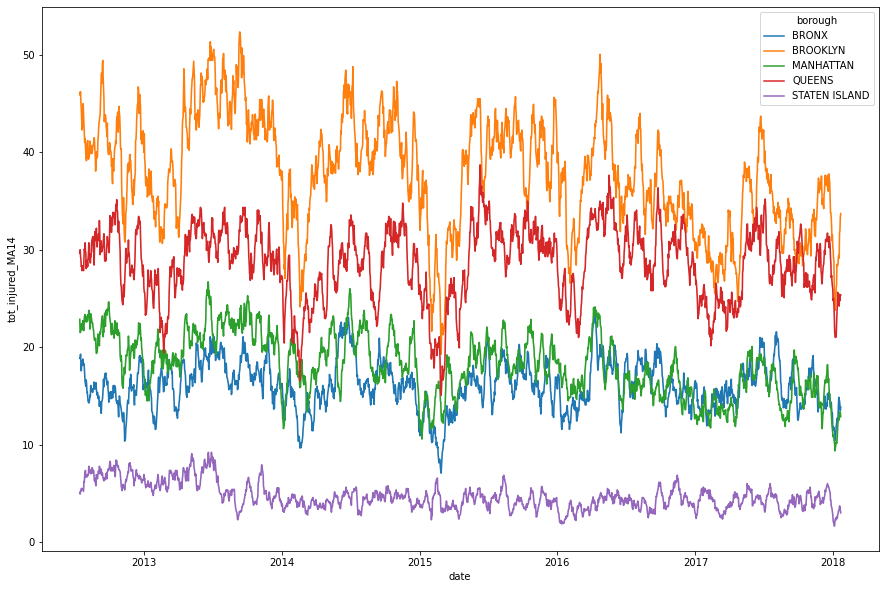

In [236]:
#daily
fig, ax = plt.subplots(figsize=(15,10))
#sns.scatterplot(x = 'date', y = 'tot_injured', data = injuries_count, hue = 'borough', ax = ax, style = 'borough', s=50, alpha = 0.1, legend = False)
g = sns.lineplot(x= 'date' , y= 'tot_injured_MA14', data = injuries_count, hue = 'borough', ax = ax, linewidth = 1.6)

In [237]:
#monthly
injuries_count = injured_df.groupby(['date', 'borough']).sum().reset_index()
injuries_count_m = injuries_count.set_index('date').groupby([pd.Grouper(freq='M'), 'borough']).sum().reset_index()
injuries_count_m['tot_injured_MA3'] = injuries_count_m.groupby('borough')['tot_injured'].\
rolling(3).mean().reset_index(0,drop=True)

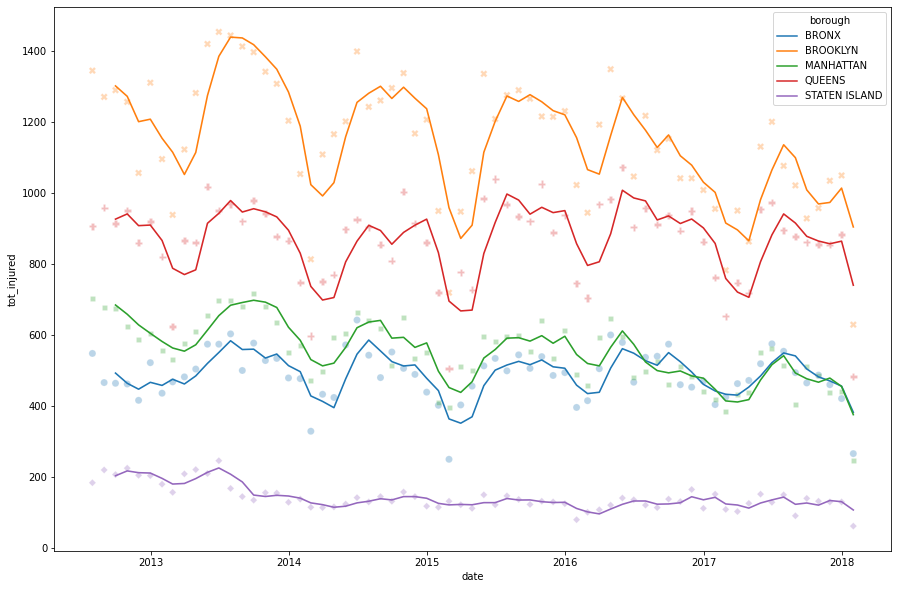

In [238]:
#monthly
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x = 'date', y = 'tot_injured', data = injuries_count_m, hue = 'borough', ax = ax, style = 'borough', s=50, alpha = 0.3, legend = False)
g = sns.lineplot(x= 'date' , y= 'tot_injured_MA3', data = injuries_count_m, hue = 'borough', ax = ax, linewidth = 1.6)

In [239]:
%%bigquery collisions_df
#number of collisions per day, by borough
SELECT
  date(timestamp) as date,
  borough,
  COUNT(unique_key) as tot_collisions
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  borough != ''
GROUP BY
  borough,
  date(timestamp) 

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10155/10155 [00:02<00:00, 3916.90rows/s]


In [240]:
collisions_df

,date,borough,tot_collisions
0,2018-01-17,QUEENS,104
1,2015-05-08,MANHATTAN,132
2,2017-11-22,QUEENS,135
3,2017-12-05,BRONX,49
4,2017-11-03,BRONX,85
...,...,...,...
10150,2016-06-05,STATEN ISLAND,5
10151,2015-01-11,STATEN ISLAND,11
10152,2015-02-25,STATEN ISLAND,1
10153,2014-08-23,STATEN ISLAND,9


In [241]:
#monthly
collisions_df['date'] = pd.to_datetime(collisions_df['date'])
collisions_count = collisions_df.groupby(['date', 'borough']).sum().reset_index()
collisions_count_m = collisions_count.set_index('date').groupby([pd.Grouper(freq='M'), 'borough']).sum().reset_index()
collisions_count_m['tot_collisions_MA6'] = collisions_count_m.groupby('borough')['tot_collisions'].\
rolling(3).mean().reset_index(0,drop=True)

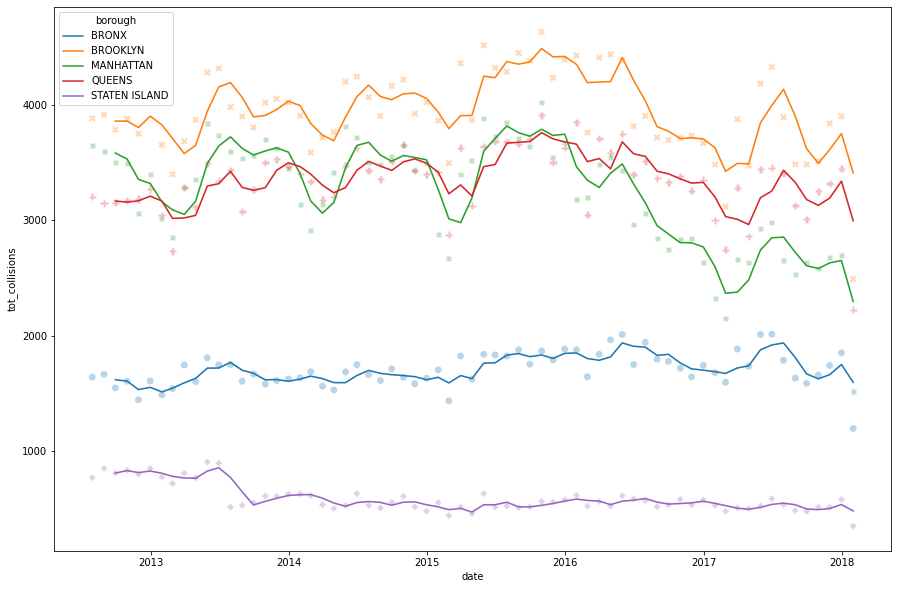

In [242]:
#monthly
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x = 'date', y = 'tot_collisions', data = collisions_count_m, hue = 'borough', ax = ax, style = 'borough', s=50, alpha = 0.3, legend = False)
g = sns.lineplot(x= 'date' , y= 'tot_collisions_MA6', data = collisions_count_m, hue = 'borough', ax = ax, linewidth = 1.6)

In [243]:
%%bigquery killed_df
#number of PERSON KILLED by borough
SELECT
  borough,
  SUM(number_of_persons_killed) as tot_kills
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  borough != ''
GROUP BY
  borough

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23rows/s]


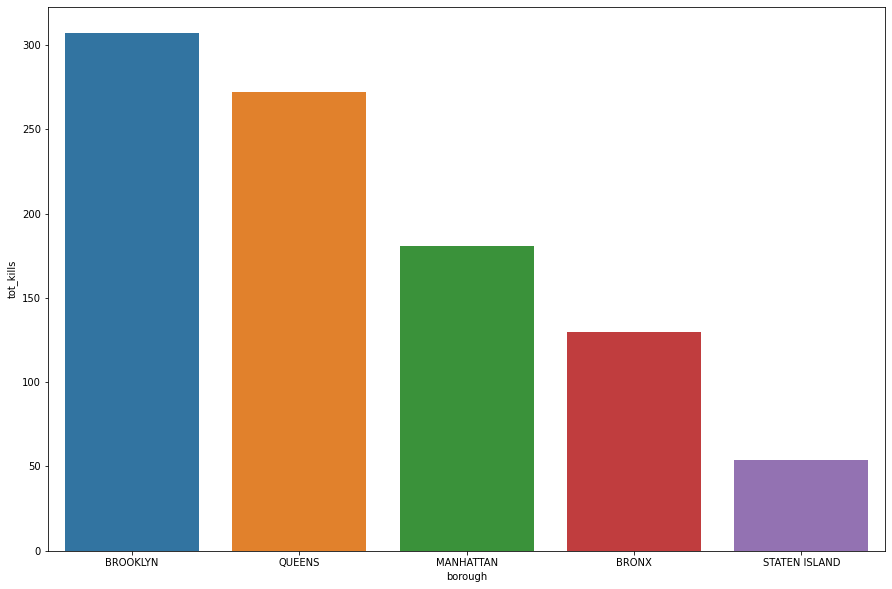

In [244]:
plt.figure(figsize=(15,10))
killed_df.sort_values(by = 'tot_kills', inplace = True, ascending = False)
ax = sns.barplot(x="borough", y="tot_kills", data=killed_df)

In [245]:
%%bigquery killed_df_acc_type
#number of collisions per day, by borough
SELECT
  borough,
  SUM(number_of_motorist_killed) as tot_kills_motorist,
  SUM(number_of_cyclist_killed) as tot_kills_cyclist,
  SUM(number_of_pedestrians_killed) as tot_kills_pedestrian
    
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  borough != ''
GROUP BY
  borough

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16rows/s]


In [246]:
killed_df_acc_type

,borough,tot_kills_motorist,tot_kills_cyclist,tot_kills_pedestrian
0,QUEENS,98,20,154
1,MANHATTAN,23,20,140
2,BRONX,44,9,77
3,STATEN ISLAND,31,2,22
4,BROOKLYN,101,29,177


In [247]:
killed_df_acc_type = killed_df_acc_type.melt(id_vars=["borough"], 
        var_name="acc_type", 
        value_name="tot_kills")

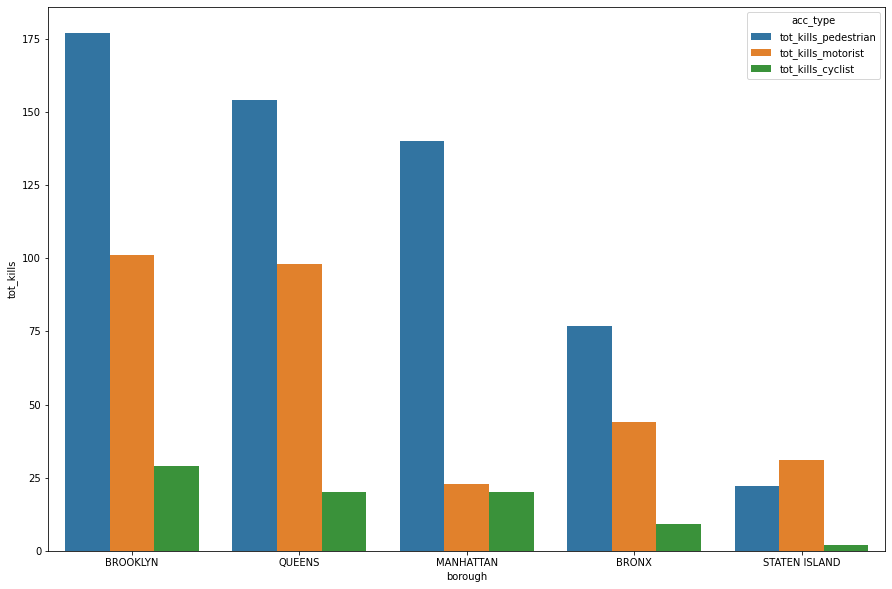

In [248]:
plt.figure(figsize=(15,10))
killed_df_acc_type.sort_values(by = 'tot_kills', inplace = True, ascending = False)
ax = sns.barplot(x="borough", y="tot_kills", hue = 'acc_type', data=killed_df_acc_type)

# Slide 3 - Focus on Brooklyn: Brooklyn big picture: causes, hours and days of accidents, ZIP codes most hit

In [249]:
%%bigquery contri_df
#top 10 contributing factors in brooklyn (we remove unspecified values)
SELECT
  contributing_factor_vehicle_1 as contri_factor,
  COUNT(unique_key) as tot_collisions
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  borough = 'BROOKLYN' and contributing_factor_vehicle_1 != 'Unspecified' and contributing_factor_vehicle_1 != ''
GROUP BY
  contributing_factor_vehicle_1

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 21.27rows/s]


In [250]:
contri_df.sort_values(by = 'tot_collisions', ascending = False)[:10]

,contri_factor,tot_collisions
3,Driver Inattention/Distraction,30524
4,Failure to Yield Right-of-Way,14382
8,Backing Unsafely,8805
6,Fatigued/Drowsy,7870
15,Lost Consciousness,5020
10,Other Vehicular,4934
16,Turning Improperly,4142
2,Following Too Closely,3967
12,Prescription Medication,3788
7,Traffic Control Disregarded,3591


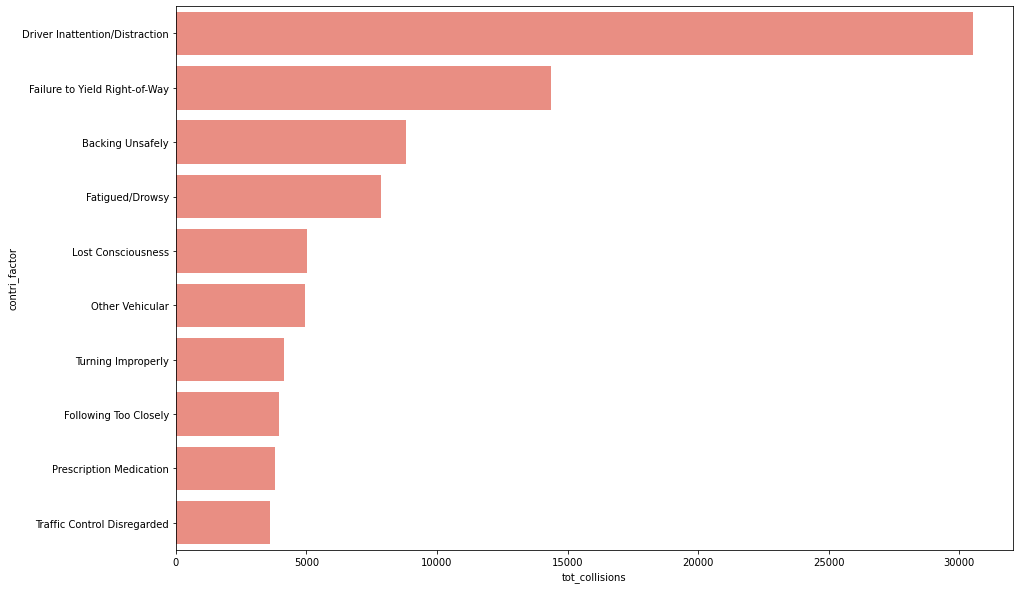

In [251]:
plt.figure(figsize=(15,10))
contri_df.sort_values(by = 'tot_collisions', inplace = True, ascending = False)
ax = sns.barplot(x="tot_collisions", y="contri_factor", data=contri_df[:10], color = 'salmon')

In [252]:
%%bigquery day_hour_df
#hours and day of accidents
SELECT
  timestamp as date,
  COUNT(unique_key) as tot_collisions
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  borough = 'BROOKLYN'
GROUP BY
  timestamp

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198054/198054 [00:03<00:00, 49569.91rows/s]


In [253]:
#dates feature engineering
day_hour_df['date'] = pd.to_datetime(day_hour_df['date'] )
day_hour_df['day_of_week'] = day_hour_df['date'].dt.day_name()
day_hour_df['date_hour'] = day_hour_df['date'].dt.hour
day_hour_df

,date,tot_collisions,day_of_week,date_hour
0,2016-10-22 23:10:00+00:00,6,Saturday,23
1,2013-09-30 07:00:00+00:00,7,Monday,7
2,2016-10-30 16:10:00+00:00,10,Sunday,16
3,2015-06-24 18:00:00+00:00,5,Wednesday,18
4,2017-12-01 18:00:00+00:00,5,Friday,18
...,...,...,...,...
198049,2016-12-08 19:12:00+00:00,4,Thursday,19
198050,2012-08-29 15:00:00+00:00,4,Wednesday,15
198051,2013-05-18 13:00:00+00:00,4,Saturday,13
198052,2016-10-27 10:10:00+00:00,4,Thursday,10


In [254]:
#hours and day of accidents
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_hour_df['day_of_week'] = pd.Categorical(day_hour_df['day_of_week'], categories=cats, ordered=True)
day_hour_df = day_hour_df.sort_values('day_of_week')
dayHour = day_hour_df.groupby(by=['day_of_week', 'date_hour']).sum()['tot_collisions'].unstack()
dayHour.head()

date_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day_of_week,,,,,,,,,,,,,,,,,,,,,
Monday,1.268546,1.079518,1.056738,1.065217,1.084871,1.114551,1.152717,1.251046,1.402597,1.405332,...,1.420942,1.458425,1.493623,1.470790,1.397183,1.333105,1.231008,1.212745,1.180046,1.156662
Tuesday,1.302564,1.089286,1.052846,1.043478,1.041667,1.063433,1.122888,1.214571,1.379106,1.409896,...,1.429022,1.455594,1.498800,1.485266,1.434620,1.356605,1.318076,1.244529,1.225368,1.147399
Wednesday,1.337413,1.072886,1.085714,1.038043,1.062222,1.049822,1.148325,1.225309,1.379482,1.365143,...,1.416495,1.456725,1.485940,1.487853,1.412453,1.359788,1.314353,1.224342,1.209452,1.145115
Thursday,1.298869,1.084548,1.062745,1.069892,1.047619,1.057878,1.134522,1.211134,1.407448,1.392935,...,1.414345,1.426690,1.535348,1.485572,1.435782,1.347654,1.252114,1.276476,1.204103,1.167842
Friday,1.310541,1.114865,1.055072,1.113043,1.052045,1.102410,1.148562,1.204927,1.365312,1.361597,...,1.432134,1.458402,1.503333,1.483467,1.424448,1.353666,1.307175,1.247849,1.255403,1.222722


<AxesSubplot:title={'center':'Collisions heatmap: weekday & hour'}, xlabel='date_hour', ylabel='day_of_week'>

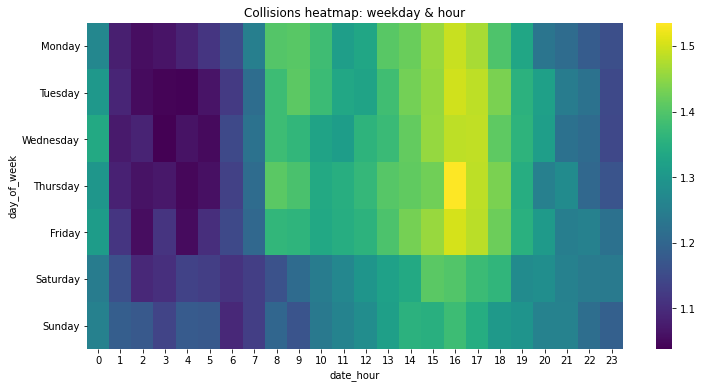

In [255]:
plt.figure(figsize=(12, 6))
plt.title('Collisions heatmap: weekday & hour')
sns.heatmap(dayHour, cmap='viridis')

## Slide 4 - Focus on Brooklyn : Focus on causes and day of weeks for actionable insights

In [256]:
%%bigquery contri_df_weekdays
#top 10 contributing factors in brooklyn (we remove unspecified values)
SELECT
  timestamp as date,
  contributing_factor_vehicle_1 as contri_factor,
  COUNT(unique_key) as tot_collisions
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  borough = 'BROOKLYN' and contributing_factor_vehicle_1 != 'Unspecified' and contributing_factor_vehicle_1 != ''
GROUP BY
  timestamp,
  contributing_factor_vehicle_1

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112131/112131 [00:02<00:00, 50905.14rows/s]


In [257]:
contri_df_weekdays

,date,contri_factor,tot_collisions
0,2017-11-13 07:10:00+00:00,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,1
1,2017-07-04 14:05:00+00:00,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,1
2,2017-12-08 15:00:00+00:00,Steering Failure,1
3,2013-05-16 16:30:00+00:00,Fell Asleep,1
4,2017-10-30 15:46:00+00:00,Steering Failure,1
...,...,...,...
112126,2015-08-12 15:46:00+00:00,Reaction to Other Uninvolved Vehicle,1
112127,2015-04-07 17:48:00+00:00,Reaction to Other Uninvolved Vehicle,1
112128,2013-01-15 14:31:00+00:00,Reaction to Other Uninvolved Vehicle,1
112129,2014-06-16 18:25:00+00:00,Reaction to Other Uninvolved Vehicle,1


In [258]:
#dates feature engineering
contri_df_weekdays['date'] = pd.to_datetime(contri_df_weekdays['date'] )
contri_df_weekdays['day_of_week'] = contri_df_weekdays['date'].dt.day_name()
contri_df_weekdays['date_hour'] = contri_df_weekdays['date'].dt.hour
contri_df_weekdays['date_day'] = contri_df_weekdays['date'].dt.date
contri_df_weekdays['is_wknd'] = contri_df_weekdays['day_of_week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

#only keep top 20 causes
top_20_causes = contri_df.sort_values(by = 'tot_collisions', ascending = False)[:20].contri_factor.to_list()
contri_df_weekdays = contri_df_weekdays[contri_df_weekdays['contri_factor'].isin(top_20_causes)]
contri_df_weekdays.head()

,date,contri_factor,tot_collisions,day_of_week,date_hour,date_day,is_wknd
5755,2013-09-30 07:00:00+00:00,Fatigued/Drowsy,1,Monday,7,2013-09-30,0
5756,2013-07-21 19:35:00+00:00,Fatigued/Drowsy,1,Sunday,19,2013-07-21,1
5757,2014-11-26 07:20:00+00:00,Fatigued/Drowsy,1,Wednesday,7,2014-11-26,0
5758,2014-08-15 19:00:00+00:00,Fatigued/Drowsy,1,Friday,19,2014-08-15,0
5759,2013-09-19 18:30:00+00:00,Fatigued/Drowsy,1,Thursday,18,2013-09-19,0


<AxesSubplot:xlabel='contri_factor', ylabel='contri_factor'>

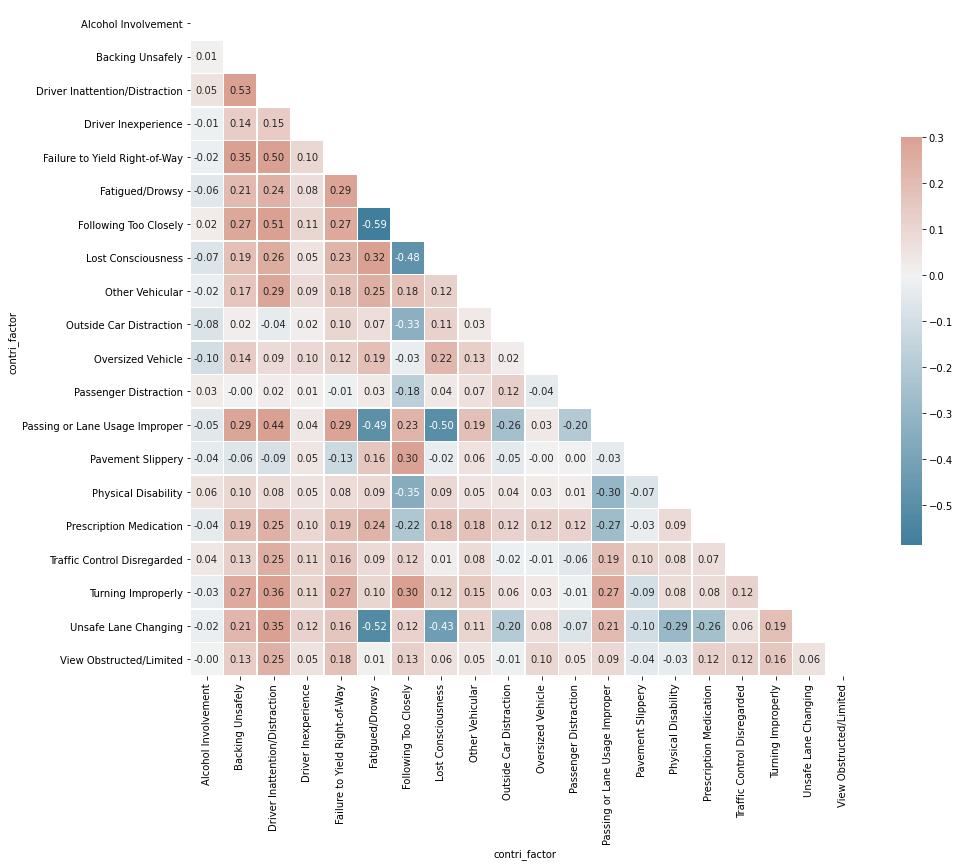

In [259]:
#driver inattention is higher during the weekdays, in particular during business hours
contri_df_day = contri_df_weekdays.groupby(['date_day', 'contri_factor']).sum()['tot_collisions'].reset_index()
contri_df_pivot = contri_df_day.pivot_table('tot_collisions', 'date_day', 'contri_factor').reset_index()

# Compute the correlation matrix
corr = contri_df_pivot.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt='.2f')

In [260]:
contri_df_inattention

,date,contri_factor,tot_collisions,day_of_week,date_hour,date_day,is_wknd
26424,2017-02-13 19:50:00+00:00,Backing Unsafely,1,Monday,19,2017-02-13,0
90176,2017-06-19 09:00:00+00:00,Driver Inattention/Distraction,1,Monday,9,2017-06-19,0
25464,2014-10-27 17:30:00+00:00,Backing Unsafely,1,Monday,17,2014-10-27,0
73262,2013-01-28 15:58:00+00:00,Failure to Yield Right-of-Way,1,Monday,15,2013-01-28,0
90168,2015-06-29 10:02:00+00:00,Driver Inattention/Distraction,1,Monday,10,2015-06-29,0
...,...,...,...,...,...,...,...
40275,2018-01-14 20:11:00+00:00,Turning Improperly,1,Sunday,20,2018-01-14,1
92738,2014-11-09 19:30:00+00:00,Driver Inattention/Distraction,1,Sunday,19,2014-11-09,1
76081,2014-01-19 10:10:00+00:00,Failure to Yield Right-of-Way,1,Sunday,10,2014-01-19,1
20736,2014-10-12 11:10:00+00:00,Backing Unsafely,1,Sunday,11,2014-10-12,1


<AxesSubplot:xlabel='day_of_week', ylabel='tot_collisions'>

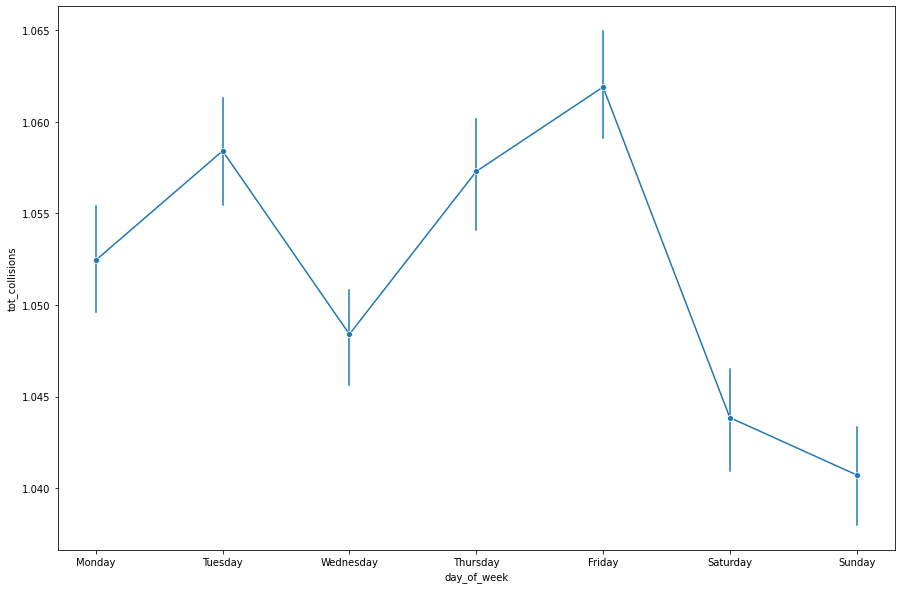

In [265]:
corr_features = [column for column in corr.columns if corr.loc['Driver Inattention/Distraction', column] >= 0.3]
contri_df_inattention = contri_df_weekdays[contri_df_weekdays['contri_factor'].isin(corr_features)].copy()
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
contri_df_inattention['day_of_week'] = pd.Categorical(contri_df_inattention['day_of_week'], categories=cats, ordered=True)
contri_df_inattention = contri_df_inattention.sort_values('day_of_week')

plt.figure(figsize=(15,10))
sns.lineplot(
    data=contri_df_inattention, x="day_of_week", y="tot_collisions",err_style="bars", ci=68, sort = False, estimator = np.mean, marker = 'o'
)

In [269]:
contri_df_inattention

,date,contri_factor,tot_collisions,day_of_week,date_hour,date_day,is_wknd
26424,2017-02-13 19:50:00+00:00,Backing Unsafely,1,Monday,19,2017-02-13,0
90176,2017-06-19 09:00:00+00:00,Driver Inattention/Distraction,1,Monday,9,2017-06-19,0
25464,2014-10-27 17:30:00+00:00,Backing Unsafely,1,Monday,17,2014-10-27,0
73262,2013-01-28 15:58:00+00:00,Failure to Yield Right-of-Way,1,Monday,15,2013-01-28,0
90168,2015-06-29 10:02:00+00:00,Driver Inattention/Distraction,1,Monday,10,2015-06-29,0
...,...,...,...,...,...,...,...
40275,2018-01-14 20:11:00+00:00,Turning Improperly,1,Sunday,20,2018-01-14,1
92738,2014-11-09 19:30:00+00:00,Driver Inattention/Distraction,1,Sunday,19,2014-11-09,1
76081,2014-01-19 10:10:00+00:00,Failure to Yield Right-of-Way,1,Sunday,10,2014-01-19,1
20736,2014-10-12 11:10:00+00:00,Backing Unsafely,1,Sunday,11,2014-10-12,1


<AxesSubplot:xlabel='tot_collisions', ylabel='is_wknd'>

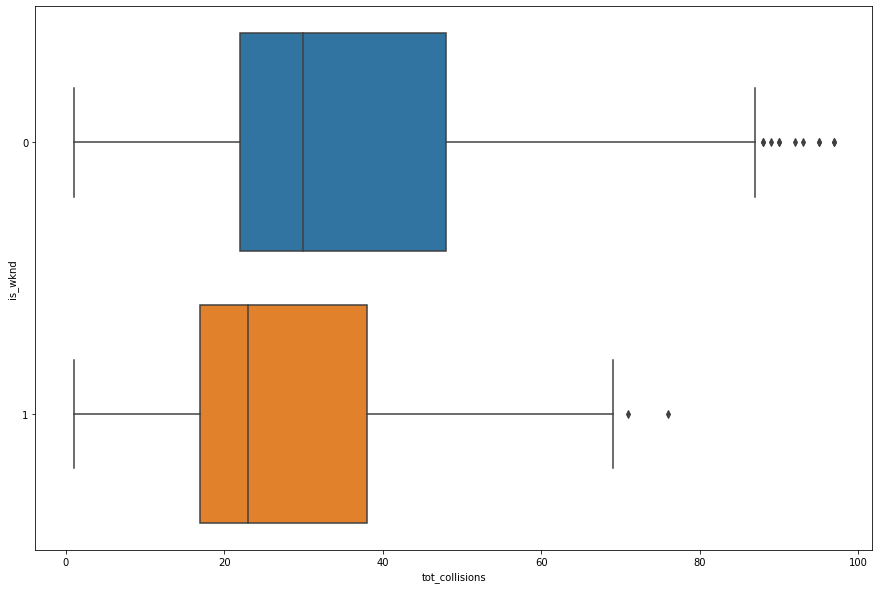

In [277]:
plt.figure(figsize=(15,10))
sns.boxplot(data = contri_df_inattention.groupby(['is_wknd', 'date_day']).sum().reset_index(), y = 'is_wknd', x = 'tot_collisions', orient = 'h')

<AxesSubplot:xlabel='day_of_week', ylabel='tot_collisions'>

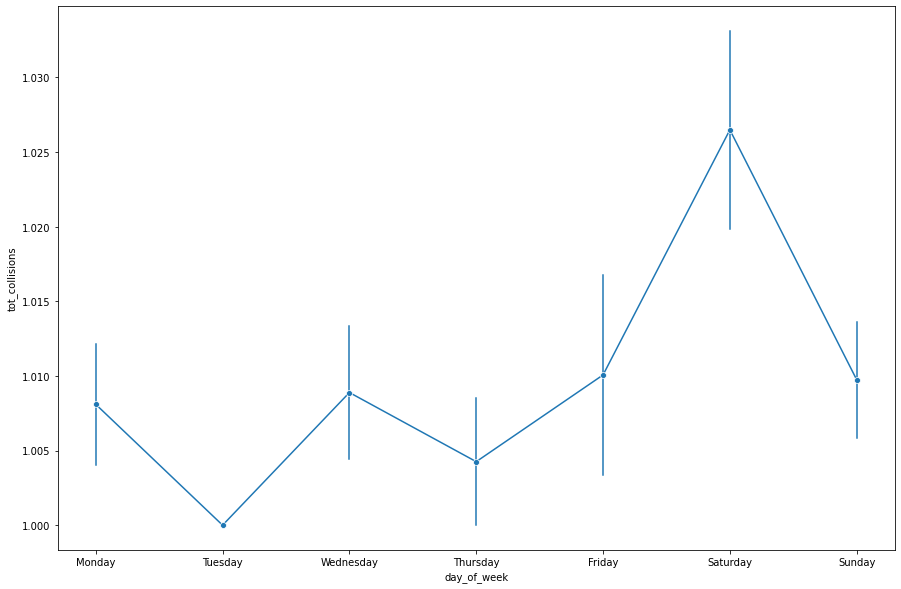

In [266]:
#alchol involvement is higher during the weekends
contri_df_alcohol = contri_df_weekdays[contri_df_weekdays['contri_factor'].isin(['Alcohol Involvement'])].copy()
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
contri_df_alcohol['day_of_week'] = pd.Categorical(contri_df_alcohol['day_of_week'], categories=cats, ordered=True)
contri_df_alcohol = contri_df_alcohol.sort_values('day_of_week')

plt.figure(figsize=(15,10))
sns.lineplot(
    data=contri_df_alcohol, x="day_of_week", y="tot_collisions",err_style="bars", ci=68, sort = False, estimator = np.mean, marker = 'o'
)

<AxesSubplot:xlabel='tot_collisions', ylabel='is_wknd'>

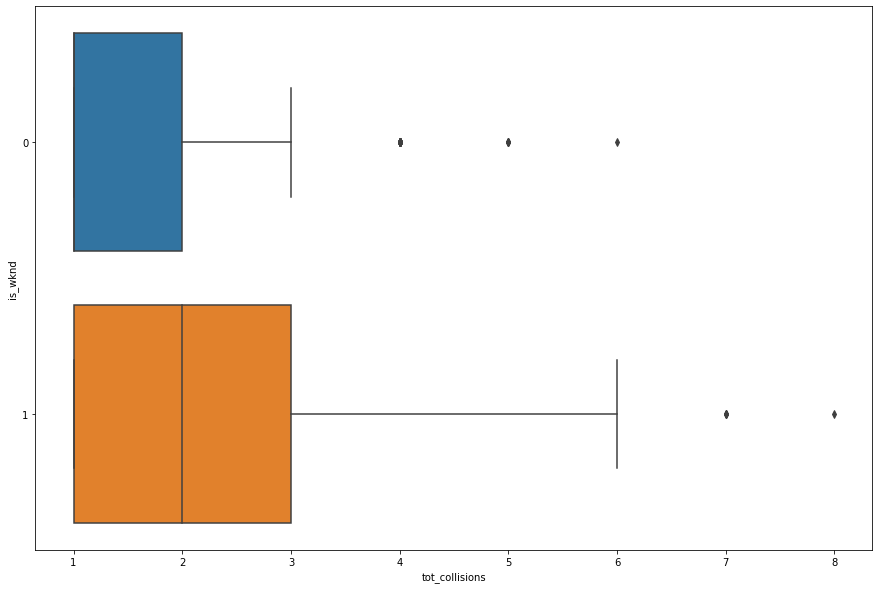

In [278]:
plt.figure(figsize=(15,10))
sns.boxplot(data = contri_df_alcohol.groupby(['is_wknd', 'date_day']).sum().reset_index(), y = 'is_wknd', x = 'tot_collisions', orient = 'h')